# Facebook Prophet to predict energy consumption

In [1]:
from prophet import Prophet
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

import sklearn
import matplotlib.pyplot as plt

In [2]:
#read data
df = pd.read_csv('Electricity consumption.csv')
df.head()

,date_time,Electricity consumption (kW)
0,1/1/2018 0:15,430
1,1/1/2018 0:30,420
2,1/1/2018 0:45,440
3,1/1/2018 1:00,420
4,1/1/2018 1:15,420


In [3]:
df.shape

(40415, 2)

In [4]:
#Check missing data
print(df.isnull().sum())

date_time                       0
Electricity consumption (kW)    0
dtype: int64


In [5]:
#change time format
df['date_time'] = pd.to_datetime(df["date_time"])

In [6]:
df.head()

,date_time,Electricity consumption (kW)
0,2018-01-01 00:15:00,430
1,2018-01-01 00:30:00,420
2,2018-01-01 00:45:00,440
3,2018-01-01 01:00:00,420
4,2018-01-01 01:15:00,420


In [7]:
df_time = df.copy()

### i. Forecast the electricity consumption (kWh) per day for the next 7 days

In [8]:
#Get rid of time from datetime
df['date_time'] = pd.to_datetime(df['date_time']).dt.normalize()

In [9]:
#groupby date and average the consumption
df_sum = pd.DataFrame(df.groupby(['date_time'],as_index=False)['Electricity consumption (kW)'].mean())
df_sum.head()

,date_time,Electricity consumption (kW)
0,2018-01-01,427.263158
1,2018-01-02,490.625000
2,2018-01-03,488.854167
3,2018-01-04,463.020833
4,2018-01-05,510.937500


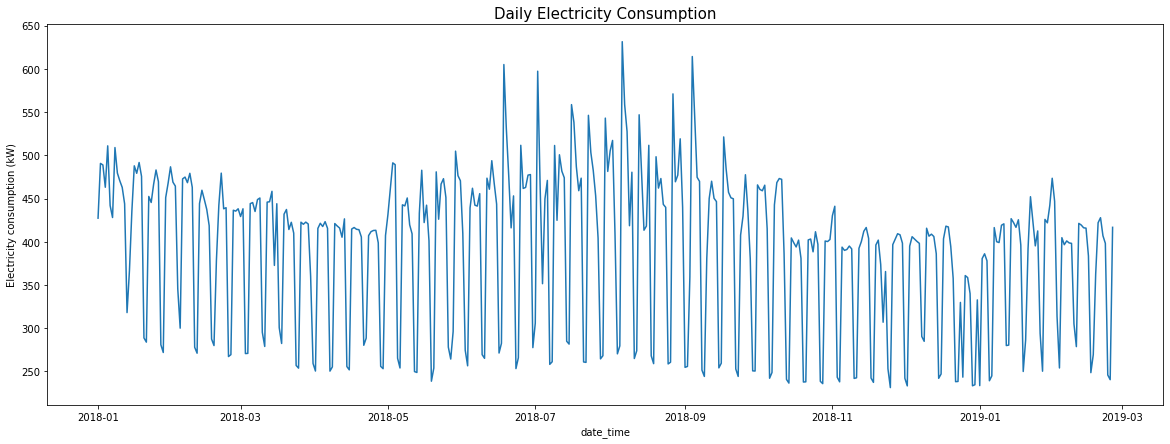

In [10]:
#Plot the time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="date_time", y="Electricity consumption (kW)", data=df_sum)
a.set_title("Daily Electricity Consumption",fontsize=15)
plt.show()

### Run Facebook Prophet Model to Predict

In [11]:
df_sum.rename(columns={'date_time': 'ds', 'Electricity consumption (kW)': 'y'}, inplace=True)

In [12]:
#make a copy of original dataframe
df_sum_copy = df_sum.copy()

In [13]:
#split the train set from original,70%
train_set = df_sum_copy.sample(frac=0.7,random_state=0)
test_set = df_sum_copy.drop(train_set.index)

### 1. Run Prophet

In [14]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(train_set)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
#set the periods as test_set ratio, 30%. Predict the next 7 days
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

In [16]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-02,469.088950,420.967250,513.112166
1,2018-01-03,472.071317,424.815512,519.389118
2,2018-01-04,465.913929,419.536507,510.550327
3,2018-01-05,458.217555,411.472411,502.134400
4,2018-01-06,304.549111,257.635864,350.085826


### 2. Compare Test and Forecast Dataset

In [17]:
test_set_forecast = m.predict(test_set)
test_set_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
119,2019-02-01,399.672181,349.990888,447.588346
120,2019-02-02,243.296717,197.461505,287.738845
121,2019-02-07,403.058707,354.640793,449.843016
122,2019-02-10,233.622633,183.743554,282.420641
123,2019-02-12,405.646306,358.678563,450.390660
124,2019-02-13,406.346521,363.815318,452.318910
125,2019-02-24,222.792425,178.782356,271.739729


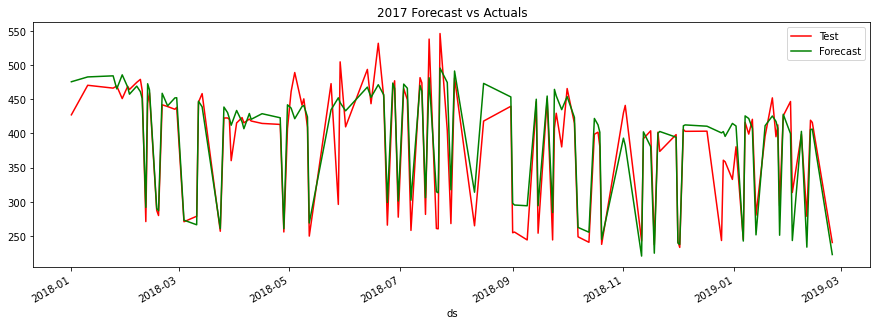

In [18]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_set.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
test_set_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('2017 Forecast vs Actuals')
plt.show()

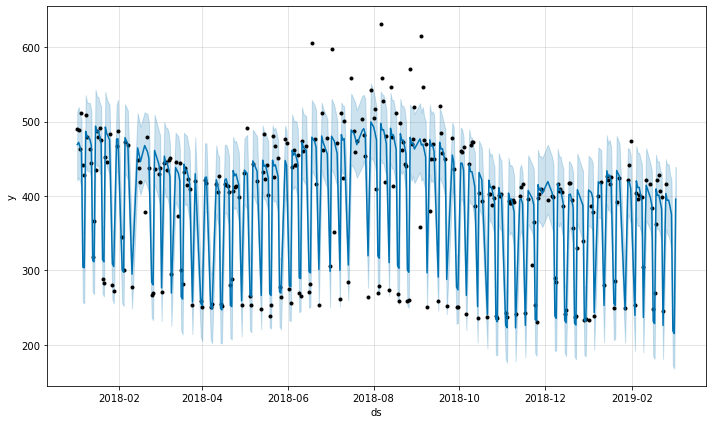

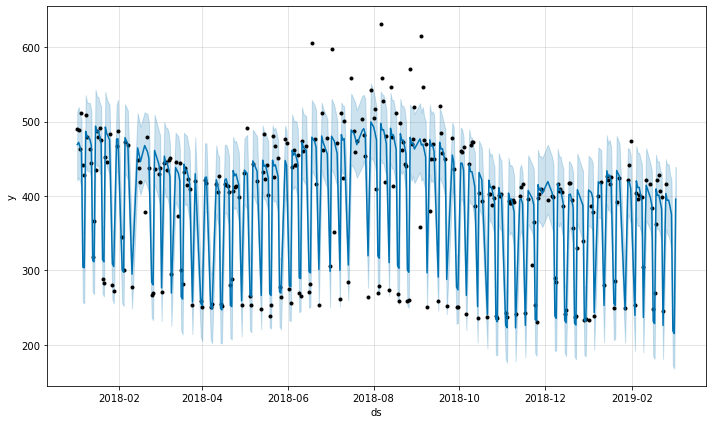

In [19]:
m.plot(forecast)

black dots: orginial data points

light blue area: confidence interval

blue line: prediction

In [20]:
#Prepare dataframe for calculate RMSLE
metric_df = forecast.set_index('ds')[['yhat']].join(df_sum.set_index('ds').y).reset_index()
metric_df.tail(7)

,ds,yhat,y
295,2019-02-26,394.210397,NaN
296,2019-02-27,394.539090,NaN
297,2019-02-28,385.674863,NaN
298,2019-03-01,375.250937,NaN
299,2019-03-02,218.867284,NaN
300,2019-03-03,215.322994,NaN
301,2019-03-04,395.817579,NaN


In [21]:
#drop the NaN value in y column, since there is no y values in prediction
metric_df.dropna(inplace=True)

#### Use RMSLE to evaluate the model

In [22]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(metric_df.y, metric_df.yhat))

0.09321222829496724

RMSLE for this model is 0.0932.

### ii.Forecast the 15min electricity demand (kW) for the next 2 days

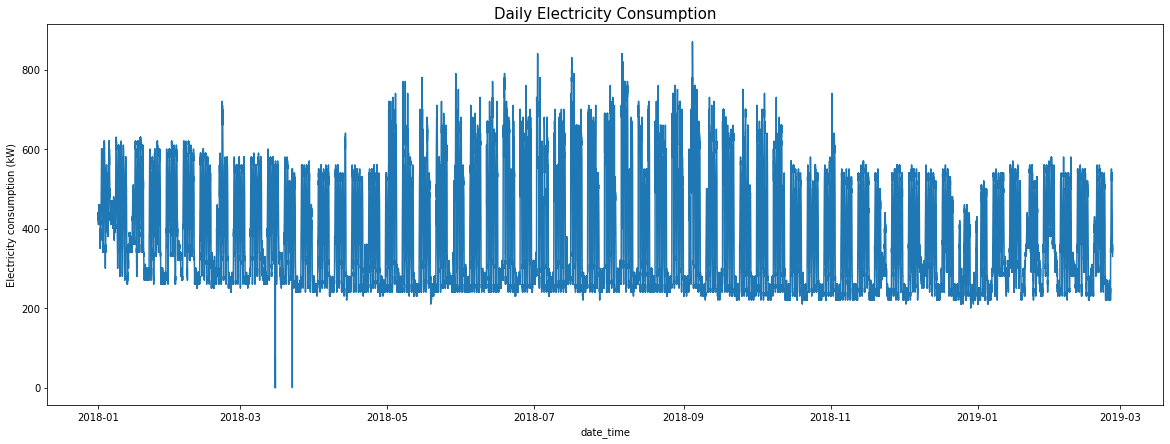

In [23]:
#Plot the time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="date_time", y="Electricity consumption (kW)", data=df_time)
a.set_title("Daily Electricity Consumption",fontsize=15)
plt.show()

### Run Facebook Prophet Model to Predict

In [24]:
df_time.rename(columns={'date_time': 'ds', 'Electricity consumption (kW)': 'y'}, inplace=True)

In [25]:
#make a copy of original dataframe
df_time_copy = df_time.copy()

In [26]:
#split the train set from original,70%
train_set = df_time_copy.sample(frac=0.7,random_state=0)
test_set = df_time_copy.drop(train_set.index)

### 1. Run Prophet 

In [27]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(train_set)

In [28]:
#set the periods as test_set ratio, 30%. Predict the next 2 days, frequency is 15 min.
future = m.make_future_dataframe(periods=192, freq="15min")
forecast = m.predict(future)

In [29]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01 00:15:00,308.877536,206.210062,406.703404
1,2018-01-01 00:30:00,308.864034,208.072540,407.743693
2,2018-01-01 00:45:00,308.437547,207.385852,409.884152
3,2018-01-01 01:00:00,307.672687,201.072954,406.772528
4,2018-01-01 01:15:00,306.698148,212.816473,412.611055


### 2. Compare Test and Forecast Dataset

In [30]:
test_set_forecast = m.predict(test_set)
test_set_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
12118,2019-02-25 17:00:00,520.168145,418.470393,622.910743
12119,2019-02-25 19:45:00,422.069942,317.454290,520.838691
12120,2019-02-25 20:00:00,408.264769,312.092795,512.267972
12121,2019-02-25 20:30:00,382.307704,286.367658,492.392952
12122,2019-02-25 22:30:00,326.616854,224.463477,426.768797
12123,2019-02-25 23:00:00,323.589269,227.633144,428.100588
12124,2019-02-25 23:15:00,322.663521,227.722785,422.685245


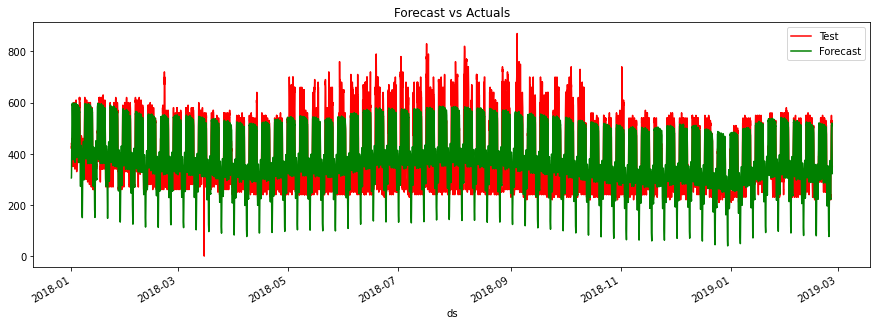

In [31]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_set.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
test_set_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

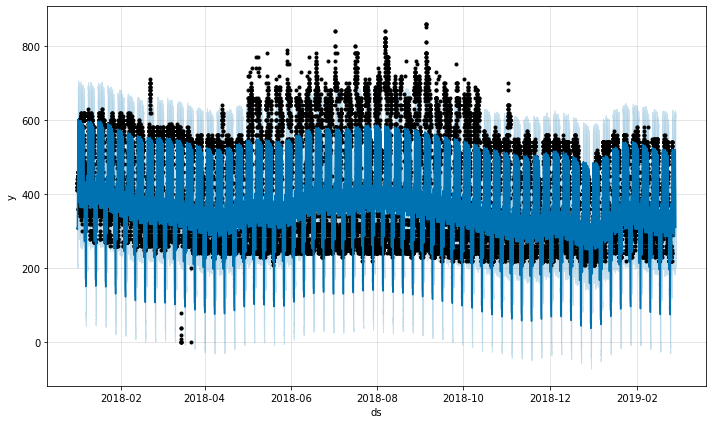

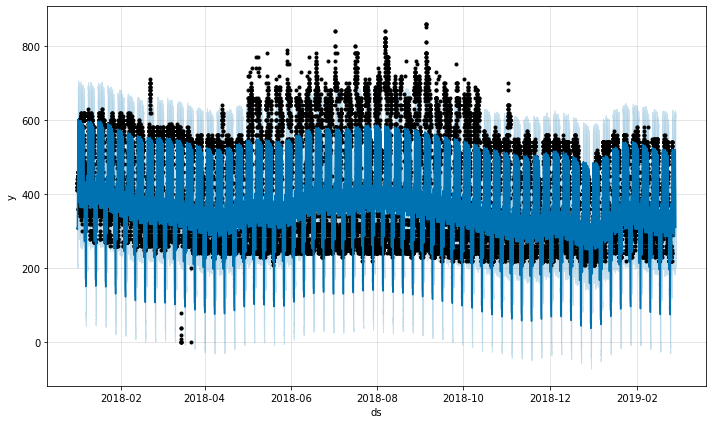

In [32]:
m.plot(forecast)

In [33]:
#Prepare dataframe for calculate RMSE
metric_df = forecast.set_index('ds')[['yhat']].join(df_sum.set_index('ds').y).reset_index()
metric_df.tail()

,ds,yhat,y
28477,2019-02-27 22:45:00,314.378630,NaN
28478,2019-02-27 23:00:00,313.037618,NaN
28479,2019-02-27 23:15:00,312.020182,NaN
28480,2019-02-27 23:30:00,311.095640,NaN
28481,2019-02-27 23:45:00,310.062936,NaN


In [34]:
metric_df.tail(192).to_csv('forecasted results 15min.csv',index=False)

In [35]:
#drop the NaN value in y column, since there is no y values in prediction
metric_df.dropna(inplace=True)

In [36]:
#calculate rmsle
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(metric_df.y, metric_df.yhat))

0.44372546040020494

### Performance for January 2019 

In [37]:
df_jan19 = metric_df[(metric_df['ds'] > '2019-01-01 00:00:00') & (metric_df['ds'] < '2019-02-01 00:00:00')]

In [38]:
#calculate rmsle
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(df_jan19.y, df_jan19.yhat))

0.4782226932954721